In [13]:
import operator
import os
import boto3

import cv2
import keras
import numpy as np
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

import matplotlib.pyplot as plt

In [4]:
print("image_dim_ordering:", keras.backend.image_dim_ordering())

image_dim_ordering: tf


In [27]:
from sagemaker import get_execution_role

role = get_execution_role()

bucket = 'okigan-ml'# source s3 bucket
card_image_trimmed_dir = 'sagemaker/goldeneye-ml/data/card-image-trimmed'
model_path = 'sagemaker/goldeneye-ml/model/weights.h5'

In [17]:
# print(boto3.Session().resource('s3').Bucket(bucket).Objects(prefix).list())

In [7]:
def create_model(num_classes, image_rows, image_cols, image_channels):
    model = Sequential()

    model.add(Convolution2D(32, 3, padding='same', input_shape=(image_rows, image_cols, image_channels,)))
    model.add(Activation('relu'))

    model.add(Convolution2D(32, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, padding='same'))
    model.add(Activation('relu'))

    model.add(Convolution2D(64, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

In [16]:
label_images_directory = './data/card-image-trimmed'
label_image_files = os.listdir(label_images_directory)
label_image_files.sort()
label_names = [os.path.splitext(f)[0] for f in label_image_files]
num_classes = len(label_names)

image_cols, image_rows, image_channels = 100, 156, 3

X = np.zeros((num_classes, image_rows, image_cols, image_channels))
y = np.zeros((num_classes,))

for index, filename in enumerate(label_image_files):
    path = os.path.join(label_images_directory, filename)
    image = cv2.imread(path)
    image = cv2.resize(image, (image_cols, image_rows))
    X[index, :, :, :] = image.astype('float32') / 255.0
    y[index] = index

y = np_utils.to_categorical(y, num_classes)

model = create_model(num_classes, image_rows, image_cols, image_channels)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

tensorboard = TensorBoard(log_dir="./logs", write_images=True)

model_output_dir = './model/'
os.makedirs(model_output_dir, exist_ok=True)
mode_basename = 'weights.h5'
model_filepath = os.path.join(model_output_dir, mode_basename)
model_checkpoint = ModelCheckpoint(filepath=model_filepath, verbose=1)

datagen.fit(X)


class My_Callback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data

    def on_epoch_end(self, epoch, logs=None):
        value = model.predict(data)
        print("prediction", max(enumerate(value[0]), key=operator.itemgetter(1)))
        return


input_path = './data/card-image-trimmed/3-red-striped-oval.png'
image = cv2.imread(input_path)
image = cv2.resize(image, (image_cols, image_rows))
data = image.reshape(1, image_rows, image_cols, image_channels)
value = model.predict(data.astype('float32') / 255)

my_callback = My_Callback(data)

model.fit_generator(datagen.flow(X, y)
                    , steps_per_epoch=1024
                    , epochs=200
                    , callbacks=[tensorboard, model_checkpoint, my_callback]
                    )

Epoch 1/200
   3/1024 [..............................] - ETA: 47:05 - loss: 8.1444 - acc: 0.0000e+00Epoch 00001: saving model to ./model/weights.h5
prediction (27, 1.0)
   3/1024 [..............................] - ETA: 45:25 - loss: 4.7873 - acc: 0.0104    Epoch 00002: saving model to ./model/weights.h5
prediction (1, 0.98742771)
   3/1024 [..............................] - ETA: 45:24 - loss: 4.3941 - acc: 0.0104  Epoch 00003: saving model to ./model/weights.h5
prediction (61, 0.013350535)
   3/1024 [..............................] - ETA: 45:35 - loss: 4.3949 - acc: 0.0208    Epoch 00004: saving model to ./model/weights.h5
prediction (12, 0.012400496)
   3/1024 [..............................] - ETA: 45:09 - loss: 4.3930 - acc: 0.0312Epoch 00005: saving model to ./model/weights.h5
prediction (4, 0.012398182)
   3/1024 [..............................] - ETA: 45:25 - loss: 4.3948 - acc: 0.0000e+00Epoch 00006: saving model to ./model/weights.h5
prediction (4, 0.01241471)
   3/1024 [......

prediction (80, 1.0)
   3/1024 [..............................] - ETA: 47:27 - loss: 4.1389 - acc: 0.0692Epoch 00033: saving model to ./model/weights.h5
prediction (80, 0.99999988)
   3/1024 [..............................] - ETA: 45:19 - loss: 4.1870 - acc: 0.0104Epoch 00034: saving model to ./model/weights.h5
prediction (80, 0.99999988)
   3/1024 [..............................] - ETA: 45:21 - loss: 4.1335 - acc: 0.0300  Epoch 00035: saving model to ./model/weights.h5
prediction (80, 0.99999988)
   3/1024 [..............................] - ETA: 45:30 - loss: 4.1237 - acc: 0.0404  Epoch 00036: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:33 - loss: 4.0758 - acc: 0.0208Epoch 00037: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:42 - loss: 4.1249 - acc: 0.0208  Epoch 00038: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [.......................

   3/1024 [..............................] - ETA: 45:25 - loss: 3.6049 - acc: 0.0821Epoch 00065: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:15 - loss: 3.6462 - acc: 0.0692Epoch 00066: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:29 - loss: 3.5821 - acc: 0.0312Epoch 00067: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:32 - loss: 3.4899 - acc: 0.0925Epoch 00068: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:31 - loss: 3.4482 - acc: 0.0417Epoch 00069: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:28 - loss: 3.4170 - acc: 0.1513Epoch 00070: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:24 - loss: 3.3145 - acc: 0.14

   3/1024 [..............................] - ETA: 45:36 - loss: 2.8119 - acc: 0.1550Epoch 00097: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:24 - loss: 2.7404 - acc: 0.2763Epoch 00098: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:39 - loss: 2.6973 - acc: 0.2335Epoch 00099: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:40 - loss: 2.4067 - acc: 0.3143Epoch 00100: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:42 - loss: 2.6375 - acc: 0.2451Epoch 00101: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:35 - loss: 2.5502 - acc: 0.2347Epoch 00102: saving model to ./model/weights.h5
prediction (80, 1.0)
   3/1024 [..............................] - ETA: 45:31 - loss: 2.5324 - acc: 0.24

   3/1024 [..............................] - ETA: 45:42 - loss: 1.8115 - acc: 0.3676Epoch 00129: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 45:30 - loss: 1.8209 - acc: 0.4185Epoch 00130: saving model to ./model/weights.h5
prediction (73, 0.99999928)
   3/1024 [..............................] - ETA: 46:28 - loss: 1.8295 - acc: 0.4185Epoch 00131: saving model to ./model/weights.h5
prediction (73, 1.0)
   3/1024 [..............................] - ETA: 45:20 - loss: 1.9304 - acc: 0.3885Epoch 00132: saving model to ./model/weights.h5
prediction (73, 1.0)
   3/1024 [..............................] - ETA: 45:15 - loss: 1.7537 - acc: 0.4369Epoch 00133: saving model to ./model/weights.h5
prediction (73, 1.0)
   3/1024 [..............................] - ETA: 45:25 - loss: 1.5988 - acc: 0.4694Epoch 00134: saving model to ./model/weights.h5
prediction (73, 0.99999869)
   3/1024 [..............................] - ETA: 45:22 - loss: 1.77

   3/1024 [..............................] - ETA: 45:34 - loss: 1.1566 - acc: 0.5699Epoch 00161: saving model to ./model/weights.h5
prediction (78, 1.0)
   3/1024 [..............................] - ETA: 45:30 - loss: 1.2831 - acc: 0.5123Epoch 00162: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 45:33 - loss: 1.2294 - acc: 0.6415Epoch 00163: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 47:45 - loss: 1.3048 - acc: 0.5202Epoch 00164: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 45:33 - loss: 1.2861 - acc: 0.4890Epoch 00165: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 45:28 - loss: 1.2034 - acc: 0.6036Epoch 00166: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 45:25 - loss: 1.1108 - acc: 0.56

   3/1024 [..............................] - ETA: 45:31 - loss: 0.6185 - acc: 0.7665Epoch 00193: saving model to ./model/weights.h5
prediction (78, 1.0)
   3/1024 [..............................] - ETA: 45:26 - loss: 0.6444 - acc: 0.7653Epoch 00194: saving model to ./model/weights.h5
prediction (78, 1.0)
   3/1024 [..............................] - ETA: 45:31 - loss: 0.7030 - acc: 0.7261Epoch 00195: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 45:21 - loss: 0.7713 - acc: 0.7653Epoch 00196: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 47:50 - loss: 0.7990 - acc: 0.7549Epoch 00197: saving model to ./model/weights.h5
prediction (72, 1.0)
   3/1024 [..............................] - ETA: 45:38 - loss: 0.8278 - acc: 0.7053Epoch 00198: saving model to ./model/weights.h5
prediction (78, 1.0)
   3/1024 [..............................] - ETA: 45:25 - loss: 1.0769 - acc: 0.69

In [21]:
model = load_model('./model/weights.h5')

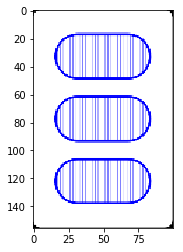

In [22]:
%matplotlib inline
input_path = './data/card-image-trimmed/3-red-striped-oval.png'

image_cols, image_rows, image_channels = 100,156,3

image = cv2.imread(input_path)
image = cv2.resize(image, (image_cols, image_rows))
plt.imshow(image)

In [23]:
input_path = './data/card-image-trimmed/3-red-striped-oval.png'
image = cv2.imread(input_path)
image = cv2.resize(image, (image_cols, image_rows))
data = image.reshape(1, image_rows, image_cols, image_channels)
value = model.predict(data.astype('float32') / 255)

# print(model.summary())
print(value)
print("max", max(enumerate(value[0]), key=operator.itemgetter(1)))

[[ 0.10464192  0.01645021  0.02927784  0.01430083  0.01065862  0.00401268
   0.03985588  0.02279379  0.00434492  0.10859834  0.12434077  0.0412313
   0.00753181  0.01518075  0.00201416  0.01623737  0.01081274  0.00125569
   0.04461015  0.00925118  0.02068374  0.00496383  0.00771386  0.00204172
   0.01200656  0.00562318  0.00086775  0.03043773  0.00667183  0.01699249
   0.00338634  0.00173015  0.00060105  0.0060127   0.00419092  0.0043122
   0.04661205  0.01869489  0.01756213  0.00132315  0.00236424  0.00082636
   0.00465464  0.00216544  0.00175151  0.02421451  0.00906622  0.00793136
   0.00548465  0.00275325  0.00160968  0.00381782  0.00425064  0.00136543
   0.00654714  0.00240699  0.00295783  0.00222472  0.00169908  0.00021776
   0.00221252  0.00247948  0.00093336  0.00962428  0.00809269  0.00575776
   0.00155552  0.00213212  0.00087646  0.00222025  0.00147163  0.00068497
   0.00851896  0.00832209  0.00496083  0.00219455  0.00149965  0.00060469
   0.0039764   0.00183434  0.00190906]]


In [25]:
for i,x in enumerate(label_image_files):
    print(i, x)

0 1-green-empty-bean.png
1 1-green-empty-diamond.png
2 1-green-empty-oval.png
3 1-green-solid-bean.png
4 1-green-solid-diamond.png
5 1-green-solid-oval.png
6 1-green-striped-bean.png
7 1-green-striped-diamond.png
8 1-green-striped-oval.png
9 1-purple-empty-bean.png
10 1-purple-empty-diamond.png
11 1-purple-empty-oval.png
12 1-purple-solid-bean.png
13 1-purple-solid-diamond.png
14 1-purple-solid-oval.png
15 1-purple-striped-bean.png
16 1-purple-striped-diamond.png
17 1-purple-striped-oval.png
18 1-red-empty-bean.png
19 1-red-empty-diamond.png
20 1-red-empty-oval.png
21 1-red-solid-bean.png
22 1-red-solid-diamond.png
23 1-red-solid-oval.png
24 1-red-striped-bean.png
25 1-red-striped-diamond.png
26 1-red-striped-oval.png
27 2-green-empty-bean.png
28 2-green-empty-diamond.png
29 2-green-empty-oval.png
30 2-green-solid-bean.png
31 2-green-solid-diamond.png
32 2-green-solid-oval.png
33 2-green-striped-bean.png
34 2-green-striped-diamond.png
35 2-green-striped-oval.png
36 2-purple-empty-bean.

In [28]:
boto3.Session().resource('s3').Bucket(bucket).Object(model_path).upload_file('./model/weights.h5')